## Predicting German Credit Risk

## Описание задачи и имеющихся данных

Задача:  
Требуется, на основании имеющихся данных о клиентах банка, построить модель, для прогнозирования невыполнения долговых обязательств.  
Целевая переменная: default

Метрика качества

F1-score (sklearn.metrics.f1_score)

Целевая метрика
* F1 > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Описание датасета:**  

Unnamed: 0 - Безымянный  
Age - Возраст  
Sex - Пол   
Job - Работа (0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)	
Housing - Жилье	
Saving accounts - Сберегательные счета	
Checking account - Расчетный счет	
Credit amount - Сумма кредита	
Duration - Продолжительность (числовое значение в месяцах)	
Purpose - Цель	
default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

## Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import graphviz

In [2]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

In [3]:
import xgboost as xgb

In [4]:
!pip3 install catboost

     |████████████████████████████████| 76.1 MB 51 kB/s 


In [5]:
import catboost as catb

Напишем функций для визуализации важности признаков и порога вероятности:

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [7]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [49]:
import warnings
warnings.filterwarnings('ignore')

## Загрузка датасета c моего Google Диска

In [8]:
!gdown --id 1-A9Cjj8R7oIstJ7_C_gkDKdOI1yZvdUr

Downloading...
From: https://drive.google.com/uc?id=1-A9Cjj8R7oIstJ7_C_gkDKdOI1yZvdUr
To: /content/german-credit.csv
100% 50.5k/50.5k [00:00<00:00, 48.8MB/s]


In [9]:
df = pd.read_csv('/content/german-credit.csv')

## Анализ данных

In [10]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,default
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,2,49,male,1,own,little,NaN,2096,12,education,0
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,4,53,male,2,free,little,little,4870,24,car,1


Видим следующее: 
1. Столбец "Unnamed: 0" содердит сквозную нумерацию, то есть не содержит никаких значимых данных.
2. Наименование столбцов выполнено с большой буквы и имеет пробелы.
3. Значения в столбце "Job" отображены в виде номинальных переменных.

In [11]:
df.dtypes

Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
default              int64
dtype: object

В каждом столбце только один тип данных, приведение типов не требуется

In [12]:
df.isna().mean()

Unnamed: 0          0.000
Age                 0.000
Sex                 0.000
Job                 0.000
Housing             0.000
Saving accounts     0.183
Checking account    0.394
Credit amount       0.000
Duration            0.000
Purpose             0.000
default             0.000
dtype: float64

Имеем пропуски в двух столбцах, при этом в столбце "Checking account" отсутсвует почти 40% данных

In [13]:
df.nunique().sort_values()

Sex                    2
default                2
Housing                3
Checking account       3
Job                    4
Saving accounts        4
Purpose                8
Duration              33
Age                   53
Credit amount        921
Unnamed: 0          1000
dtype: int64

Видим, что неприрывными являются значения только в трех столбцах (не считая Unnamed: 0).

## Предобработка данных

### Удаление столбца "Unnamed: 0" и переименование остальных столбцов

In [14]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [15]:
df.columns = df.columns.str.replace(' ','_').str.lower()

In [16]:
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


### Целевая переменная

In [17]:
df['default'].value_counts()

0    700
1    300
Name: default, dtype: int64

Имеем дисбаланс по целевой переменной 30/70

### Признаковое пространство

#### Количественные (числовые) признаки


In [18]:
df.iloc[:, :-1].select_dtypes(include='int64').columns.tolist()

['age', 'job', 'credit_amount', 'duration']

* age - возраст

In [19]:
df['age'].describe()

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age, dtype: float64

Неправдоподобно маленьких/больших значений не выявлено

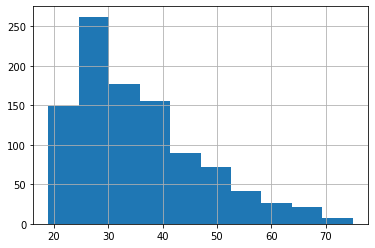

In [20]:
df['age'].hist()

Большая чать клиентов находятся в диапазоне от 20 до 40 (очень грубо)

* job - работа

In [21]:
df['job'].value_counts(normalize=True)

2    0.630
1    0.200
3    0.148
0    0.022
Name: job, dtype: float64

Как таковым количественным признаком не является, так как категориальное значение закодировано в виде номинальной переменной (0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled) 

Выполню техническую замену (раскодирование) для преобразовани количественных значений в категориальные

In [22]:
df.loc[df['job'] == 0, 'job'] = 'unskilled and non-resident'
df.loc[df['job'] == 1, 'job'] = 'unskilled and resident'
df.loc[df['job'] == 2, 'job'] = 'skilled'
df.loc[df['job'] == 3, 'job'] = 'highly skilled'

In [23]:
df['job'].value_counts()

skilled                       630
unskilled and resident        200
highly skilled                148
unskilled and non-resident     22
Name: job, dtype: int64

Имеем значительный дисбаланс в сторону "skilled" (квалифицированный)

* credit_amount - сумма кредита

In [24]:
df['credit_amount'].describe()

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: credit_amount, dtype: float64

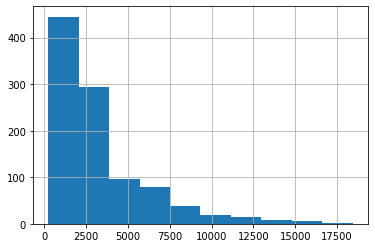

In [25]:
df['credit_amount'].hist()

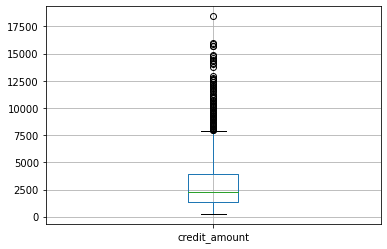

In [26]:
df.boxplot('credit_amount')

Распределение асимметричное, в связи с чем "выбросы", которые видим на boxplot, как таковыми выбросами не считаю (так называемый "жирный хвост")

* duration - продолжительность (числовое значение в месяцах)

In [27]:
df['duration'].describe()

count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: duration, dtype: float64

Неправдоподобно маленьких/больших значений не выявлено

#### Качественные (категориальные) признаки

In [28]:
df.select_dtypes(include='object').columns.tolist()

['sex', 'job', 'housing', 'saving_accounts', 'checking_account', 'purpose']

* sex - пол

In [29]:
df['sex'].value_counts()

male      690
female    310
Name: sex, dtype: int64

Имеем значительный дисбаланс в сторону "male" (мужчина)

* housing - жилье

In [30]:
df['housing'].value_counts()

own     713
rent    179
free    108
Name: housing, dtype: int64

Имеем значительный дисбаланс в сторону "own" (собственность)

* saving_accounts - Сберегательные счета

In [31]:
df['saving_accounts'].value_counts()

little        603
moderate      103
quite rich     63
rich           48
Name: saving_accounts, dtype: int64

In [32]:
sum(df['saving_accounts'].isnull().astype(int))

183

Предполагаю, что пустые значения - это не пропуски, а отсутствие сберегательного счета, поэтому выполню техническую замену

In [33]:
df['saving_accounts'] = df['saving_accounts'].fillna('no')

In [34]:
df['saving_accounts'].value_counts()

little        603
no            183
moderate      103
quite rich     63
rich           48
Name: saving_accounts, dtype: int64

* checking_account - Расчетный счет

In [35]:
df['checking_account'].value_counts()

little      274
moderate    269
rich         63
Name: checking_account, dtype: int64

In [36]:
sum(df['checking_account'].isnull().astype(int))

394

Большое кол-во пропусков (большая часть), поэтому предсказывать или отбрасывать значения нет возможности. Предполагаю, что это не пропуски, а отсутствие у клиента расчетного счета, поэтому выполню техническую замену

In [37]:
df['checking_account'] = df['checking_account'].fillna('no')

In [38]:
df['checking_account'].value_counts()

no          394
little      274
moderate    269
rich         63
Name: checking_account, dtype: int64

* purpose - цель

In [39]:
df['purpose'].value_counts()

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: purpose, dtype: int64

In [40]:
df.groupby(['purpose'])[['default']].agg(['count','mean'])

default          
                      count      mean
purpose                              
business                 97  0.350515
car                     337  0.314540
domestic appliances      12  0.333333
education                59  0.389831
furniture/equipment     181  0.320442
radio/TV                280  0.221429
repairs                  22  0.363636
vacation/others          12  0.416667

Укрупним классы по смыслу и сохранению распределения относительно целевой переменной:
* объединим domestic appliances (бытовая техника) и radio/TV 
* объединим education (образование), repairs (ремонт), vacation/others (отпуск/другие) 

In [41]:
df.loc[df['purpose'] == 'radio/TV', 'purpose'] = 'domestic appliances'

In [42]:
important_purpose = ['car', 'domestic appliances', 'furniture/equipment', 'business']

df.loc[~df['purpose'].isin(important_purpose), 'purpose'] = 'other'

In [43]:
df['purpose'].value_counts()

car                    337
domestic appliances    292
furniture/equipment    181
business                97
other                   93
Name: purpose, dtype: int64

## Графический анализ

### Количественные (числовые) признаки в разрезе целевой переменной

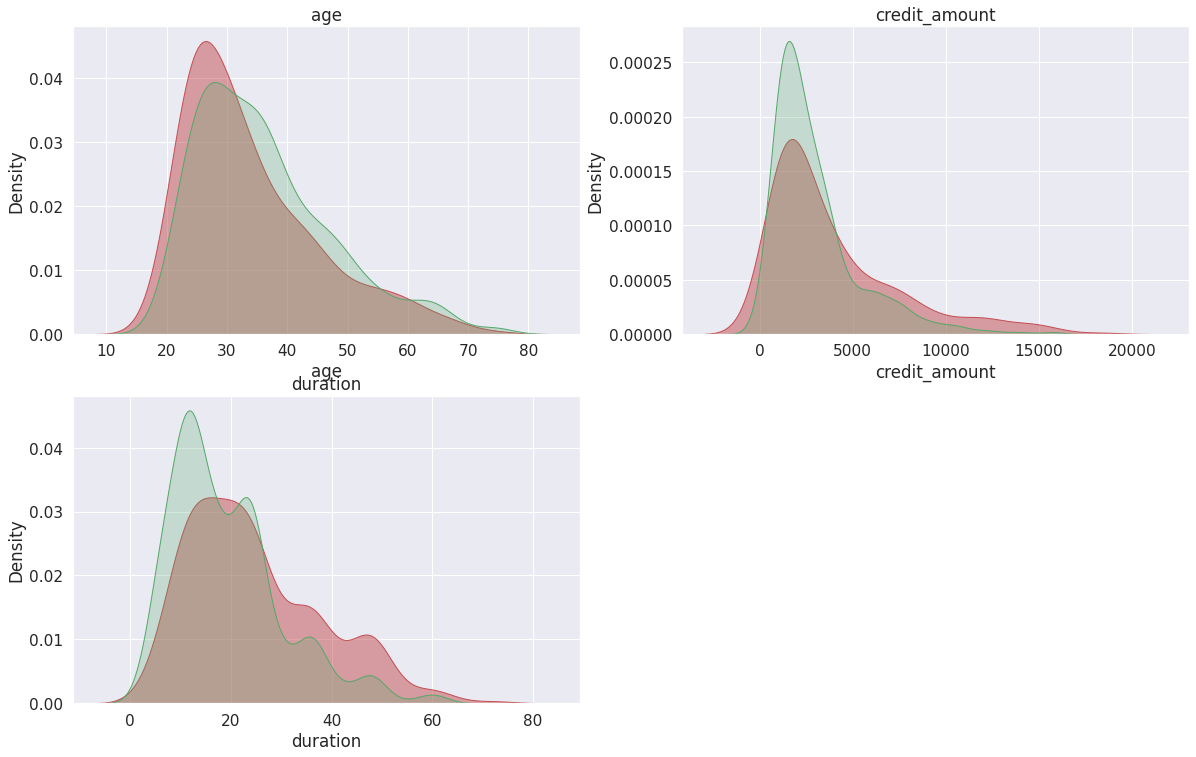

In [45]:
sns.set(font_scale=1.4)
plt.figure(figsize=(20,60))

for i, colname in enumerate(['age', 'credit_amount', 'duration']):
    plt.subplot(9,2,i+1)
    plt.title(colname)
    sns.kdeplot(x=df.loc[df['default'] == 1, colname], shade=True, alpha=0.5, legend=False, color='r')
    sns.kdeplot(x=df.loc[df['default'] == 0, colname], shade=True, legend=False, color='g')
    
plt.show()

Выводы:
* Клиенты в возрасте от 19 до 32 менее обязательные, а от 32 до 55 наоборот 
* По большим кредитам, с более долгим сроком возврата чаще просрочка (что логичо)

### Качественные (категориальные) признаки в разрезе целевой переменной

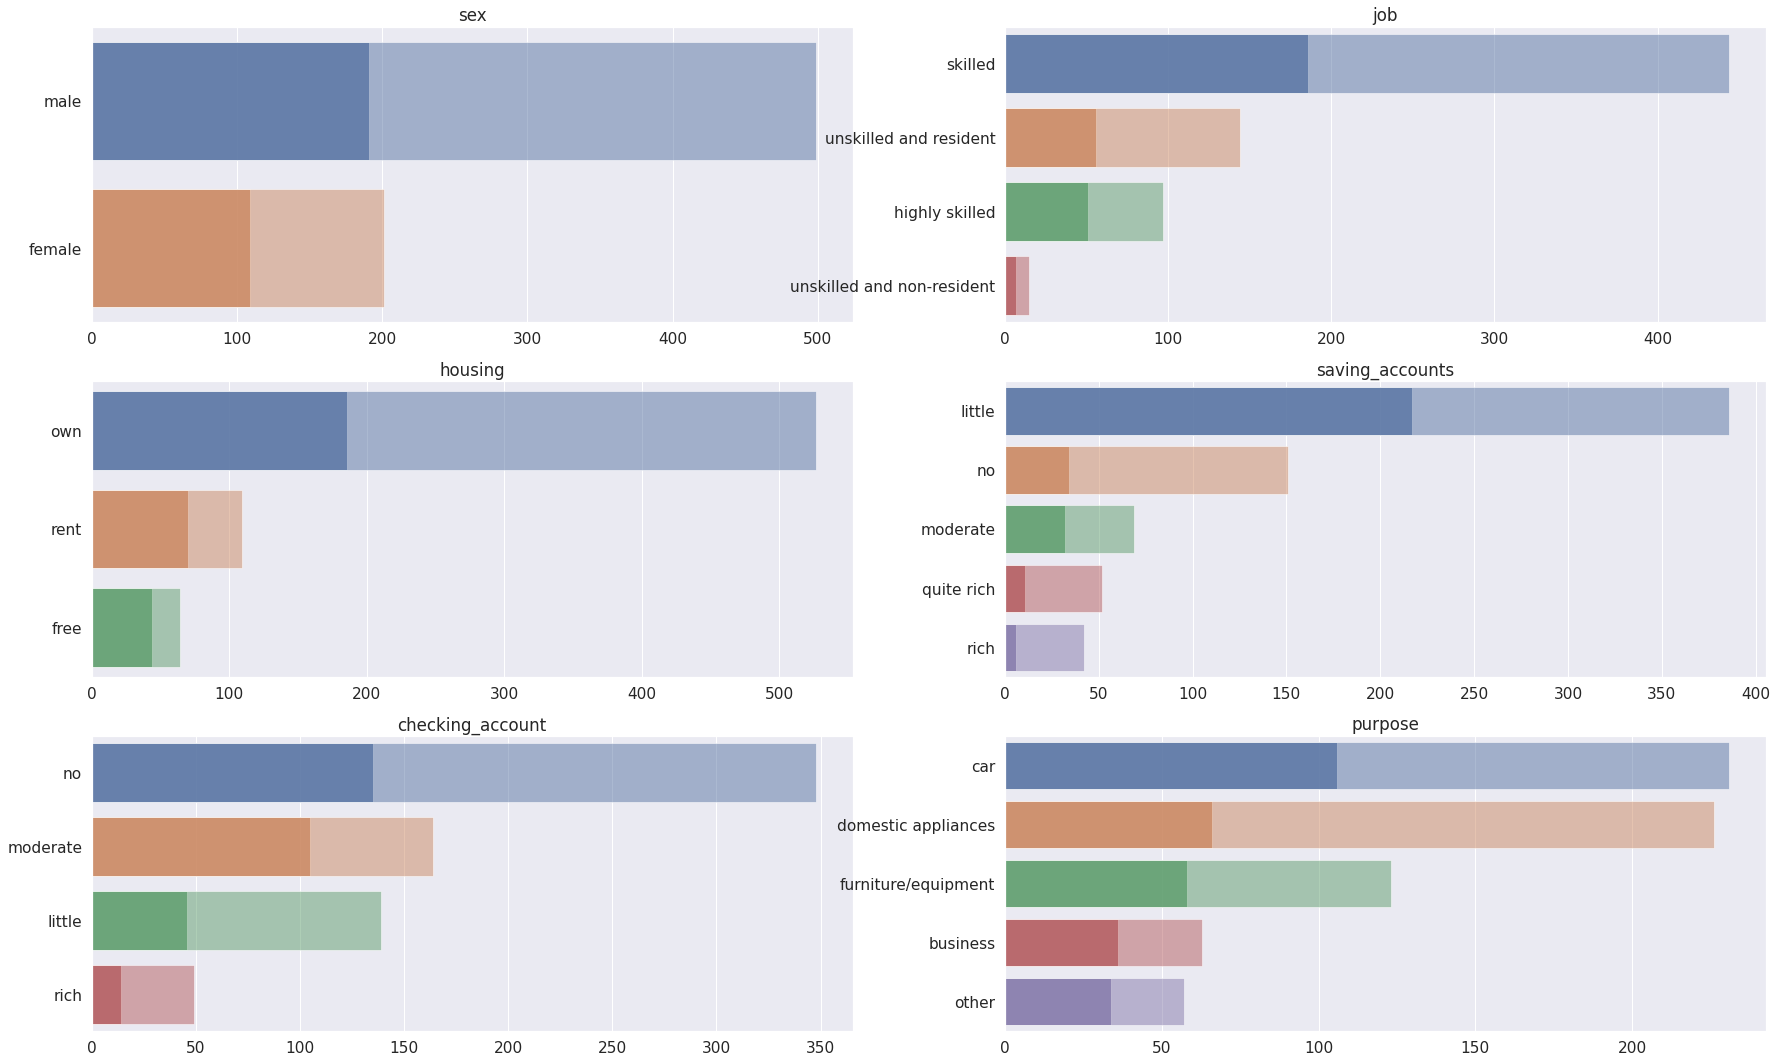

In [48]:
sns.set(font_scale=1.4)
plt.figure(figsize=(30,25))

for i, colname in enumerate(['sex', 'job', 'housing', 'saving_accounts', 'checking_account', 'purpose']):
    plt.subplot(4,2,i+1)
    plt.title(colname)
    
    val_counts_t1 = df.loc[df['default'] == 1, colname].value_counts()
    val_counts_t0 = df.loc[df['default'] == 0, colname].value_counts()
    
    sns.barplot(x=val_counts_t1.values, y=val_counts_t1.index, alpha=0.8)
    sns.barplot(x=val_counts_t0.values, y=val_counts_t0.index, alpha=0.5)
    
plt.show()

Выводы:
* Квалифицированые клиеты более обязательные. Считаю данный перекос связан с дибалансом в кол-ве значений (ранее было выявлео что квалифицированных клиентов больше всех с зачительным перевесом). Думаю зависимость связана с влияием других переменых
* Женщины чаще допускают просрочку. 

### Оценка корреляций с целевой переменной

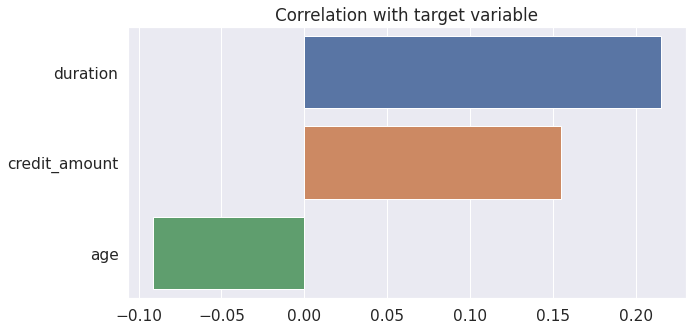

In [ ]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 5))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Сильной линейной зависимости по отношению к целевой переменной у количественных (числовых) признаков не наблюдается 

### Анализ линейных зависимостей в признаковом пространстве

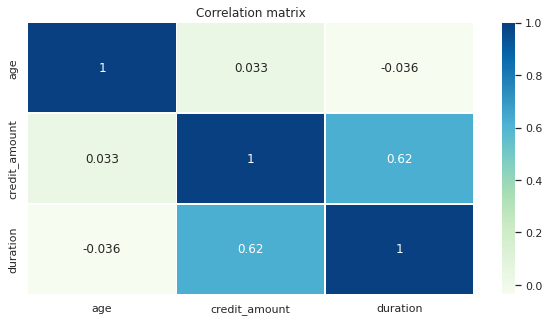

In [ ]:
plt.figure(figsize=(10,5))

sns.set(font_scale=1)
sns.heatmap(df.drop(columns='default').corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


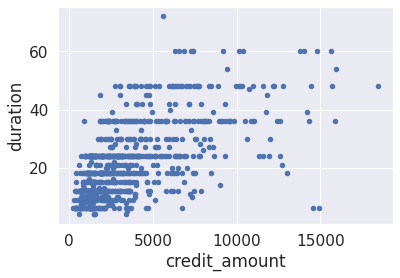

In [50]:
df.plot(x = 'credit_amount', y = 'duration', kind = 'scatter')

При этом имеется линейная зависимость у двух признаков между собой: credit_amount и duration

## Подготовка данных для работы моделей

### Создание синтетических главных компонентов

In [ ]:
important_features = ['age', 'credit_amount', 'duration']

In [ ]:
n = 2
component_names = ['component_' + str(i+1) for i in range(n)]

In [ ]:
pca = PCA(n_components=n)

train_components = pca.fit_transform(df[important_features])
train_components = pd.DataFrame(data=train_components, columns=component_names)

In [ ]:
df = pd.concat([df, train_components], axis=1)

In [ ]:
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,component_1,component_2
0,67,male,skilled,own,no,little,1169,6,domestic appliances,0,-2102.286132,32.889919
1,22,female,skilled,own,little,moderate,5951,48,domestic appliances,1,2679.802987,-17.286115
2,49,male,unskilled and resident,own,little,no,2096,12,other,0,-1175.275798,14.428937
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,0,4610.783100,7.105541
4,53,male,skilled,free,little,little,4870,24,car,1,1598.746858,17.169679


### Исключение зависимых признаков

В связи с тем, что выявлена внутренняя корреляция в признаках credit_amount и duration, исключим один из них:

In [ ]:
df.drop('credit_amount', axis=1, inplace=True)

In [ ]:
df.head()

,age,sex,job,housing,saving_accounts,checking_account,duration,purpose,default,component_1,component_2
0,67,male,skilled,own,no,little,6,domestic appliances,0,-2102.286132,32.889919
1,22,female,skilled,own,little,moderate,48,domestic appliances,1,2679.802987,-17.286115
2,49,male,unskilled and resident,own,little,no,12,other,0,-1175.275798,14.428937
3,45,male,skilled,free,little,little,42,furniture/equipment,0,4610.783100,7.105541
4,53,male,skilled,free,little,little,24,car,1,1598.746858,17.169679


### Кодирование категориальных признаков

In [ ]:
df = pd.get_dummies(df, columns=['sex', 'job', 'housing', 'saving_accounts', 'checking_account', 'purpose'], drop_first=True)
df.tail()

,age,duration,default,component_1,component_2,sex_male,job_skilled,job_unskilled and non-resident,job_unskilled and resident,housing_own,housing_rent,saving_accounts_moderate,saving_accounts_no,saving_accounts_quite rich,saving_accounts_rich,checking_account_moderate,checking_account_no,checking_account_rich,purpose_car,purpose_domestic appliances,purpose_furniture/equipment,purpose_other
995,31,12,0,-1535.276885,-3.400128,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0
996,40,30,0,585.764783,2.937707,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
997,38,12,0,-2467.272632,3.153201,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
998,23,45,1,-1426.190220,-17.214761,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
999,27,45,0,1304.800550,-12.312540,1,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0


### Разбиение на train и test

In [ ]:
X = df.drop(columns='default')
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)

### Балансировка целевой переменной

**Расчет весов для класса**

In [ ]:
compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=df['default'])

array([0.71428571, 1.66666667])

## Базовая модель

### Деревья решений

**Построение дерева**

In [ ]:
tree_clf = DecisionTreeClassifier(class_weight={0:0.71428571, 1:1.66666667})
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.71428571, 1: 1.66666667})

**Визуализация дерева**

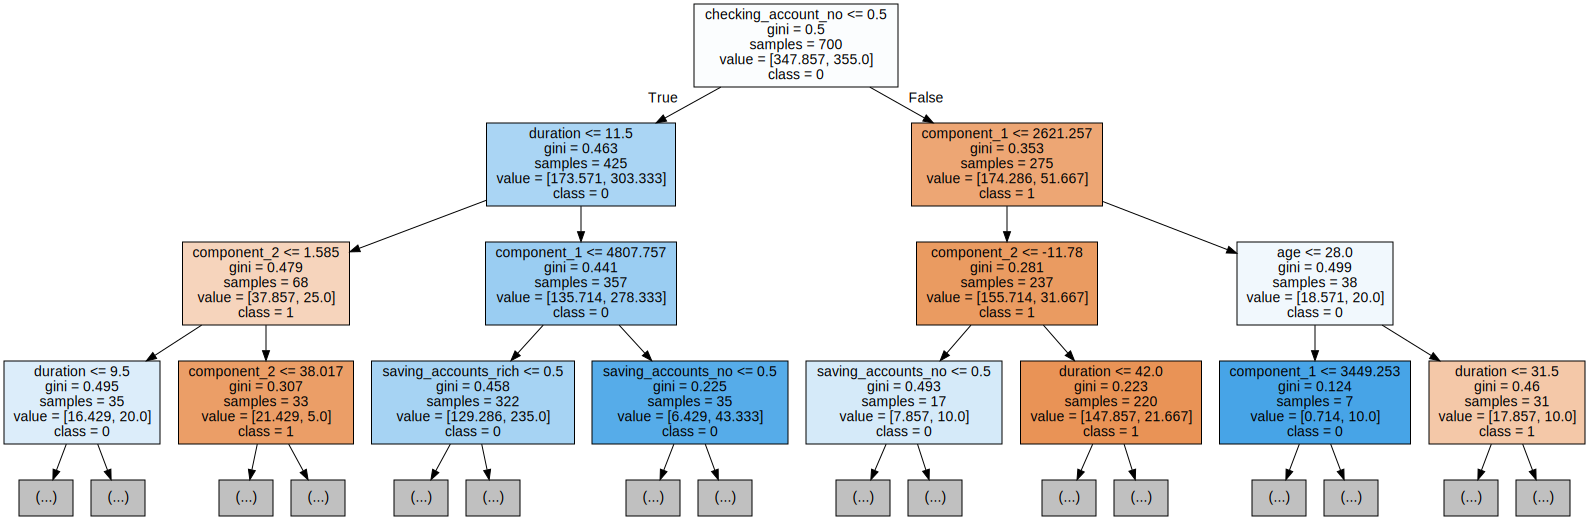

In [ ]:
dot_data = tree.export_graphviz(tree_clf, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=y_train.unique().astype(str),
                                max_depth=3, 
                                filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

**Важность признаков**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


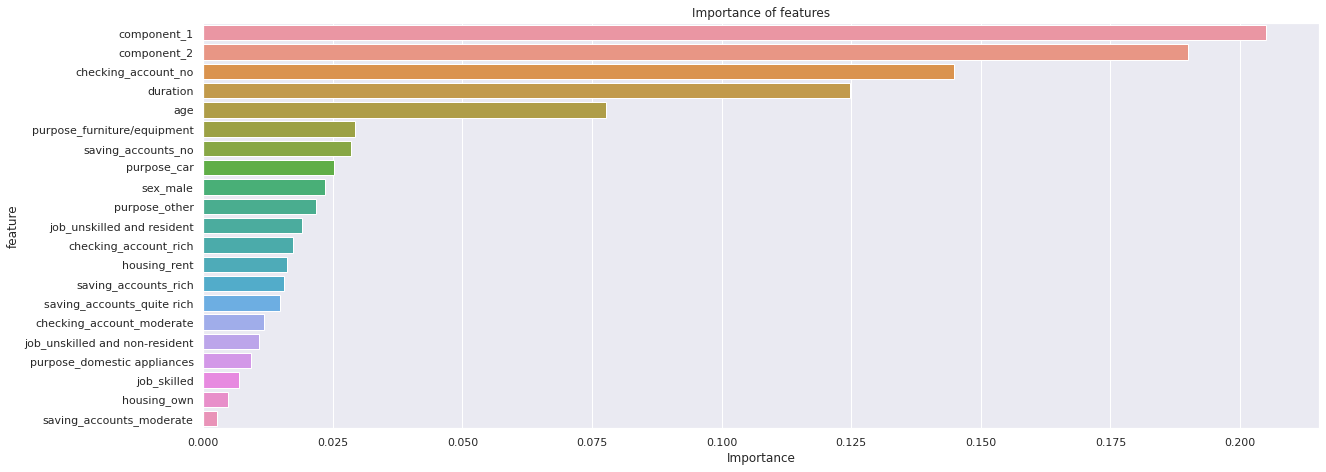

In [ ]:
show_feature_importances(X_train.columns, tree_clf.feature_importances_)

**Оценка качества**

In [ ]:
y_test_pred = tree_clf.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78       213
           1       0.47      0.52      0.49        87

    accuracy                           0.69       300
   macro avg       0.63      0.64      0.63       300
weighted avg       0.70      0.69      0.69       300



### Случайный лес

**Обучение алгоритма**

In [ ]:
random_forest_clf = RandomForestClassifier(class_weight={0: 0.71428571, 1: 1.66666667})
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.71428571, 1: 1.66666667})

**Оценка качества**

In [ ]:
y_test_pred = random_forest_clf.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       213
           1       0.63      0.36      0.46        87

    accuracy                           0.75       300
   macro avg       0.70      0.64      0.65       300
weighted avg       0.74      0.75      0.73       300



### Градиентный бустинг

**Обучение алгоритма**

In [ ]:
boostig_clf = GradientBoostingClassifier(subsample=0.7)
boostig_clf.fit(X_train, y_train)

GradientBoostingClassifier(subsample=0.7)

**Оценка качества**

In [ ]:
y_test_pred = boostig_clf.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.82       213
           1       0.53      0.38      0.44        87

    accuracy                           0.72       300
   macro avg       0.65      0.62      0.63       300
weighted avg       0.70      0.72      0.71       300



### Выводы по базовой модели

Из базовых алгоритмов лучше всех себя показало дерево решений, слегка не дотянув до целевой метрике. Попробую применить более продвинутые алгоритмы

## Применение продвинутых бустингов

### XGBoost:

In [ ]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [ ]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

In [ ]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3,
    'scale_pos_weight' : ratio} 

steps = 20

In [ ]:
model_xgb = xgb.train(param, D_train, steps)

In [ ]:
preds = model_xgb.predict(D_test)
y_test_pred = np.asarray([np.argmax(line) for line in preds])

In [ ]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.90      0.82       213
           1       0.55      0.30      0.39        87

    accuracy                           0.73       300
   macro avg       0.66      0.60      0.61       300
weighted avg       0.70      0.73      0.70       300



С минимальной настройкой алгоритма результат по качеству прогноза для главного класса совсем не впечатляет 

### CatBoost:

**Обучение алгоритма**

In [ ]:
model_catb = catb.CatBoostClassifier(class_weights=[0.71, 1.67], silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       213
           1       0.54      0.67      0.60        87

    accuracy                           0.74       300
   macro avg       0.70      0.72      0.70       300
weighted avg       0.76      0.74      0.75       300



Результат гораздо лучше и по сути уже позволяет считать задачу выполненной. Но постараемся дополнительно настроить нашу модель

In [ ]:
model_catb.get_all_params()

{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'class_names': [0, 1],
 'class_weights': [0.7099999785423279, 1.6699999570846558],
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'Logloss',
 'feature_border_type': 'GreedyLogSum',
 'force_unit_auto_pair_weights': False,
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 10,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.008847000077366829,
 'loss_function': 'Logloss',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 21,
 'random_strength': 1,
 'rsm': 1,
 '

#### Подбор гиперпараметров

Поиск по сетке, чтобы найти оптимальные параметры

In [ ]:
params = {'depth': [5, 6, 7], # 6
          'learning_rate': [0.01, 0.0088, 0.007], # 0.0088
          'iterations': [500, 1000, 1500]} # 1000

In [ ]:
cb = catb.CatBoostClassifier(class_weights=[0.71, 1.67], random_state=21)
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv=3)

In [ ]:
cb_model.fit(X_train, y_train)

In [ ]:
# Посмотреть лучший результат
print(cb_model.best_score_)

0.7652447035973827


In [ ]:
# Просмотр лучших параметров
print(cb_model.best_params_)

{'depth': 6, 'iterations': 500, 'learning_rate': 0.01}


Примеяем полученные параметры

In [ ]:
model_catb = catb.CatBoostClassifier(class_weights=[0.71, 1.67], silent=True, random_state=21, depth=6, iterations=500, learning_rate=0.01)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       213
           1       0.56      0.71      0.63        87

    accuracy                           0.75       300
   macro avg       0.71      0.74      0.72       300
weighted avg       0.78      0.75      0.76       300



#### Важность признаков

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


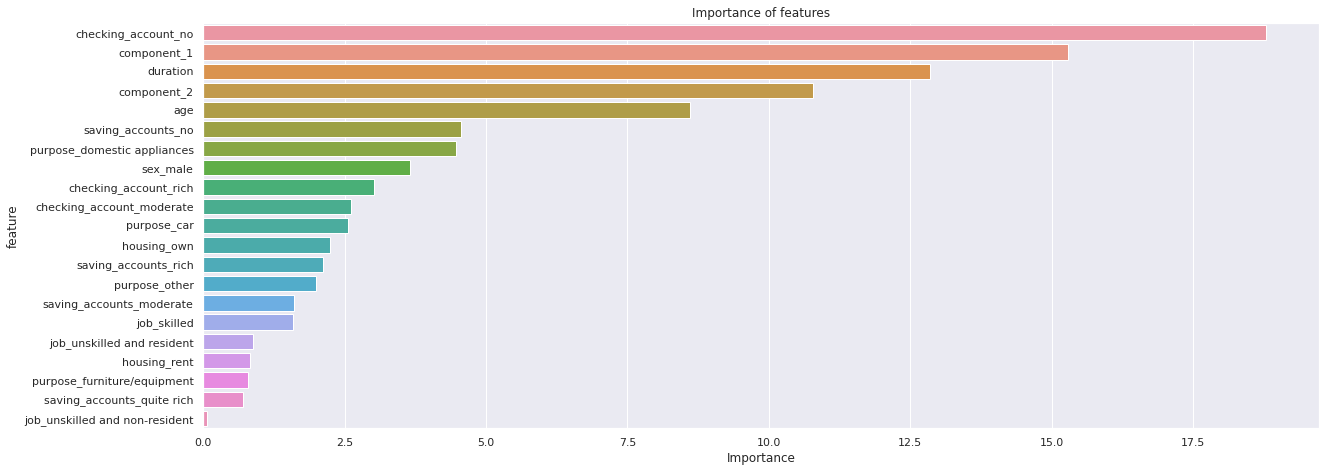

In [ ]:
show_feature_importances(X.columns, model_catb.feature_importances_)

#### Выбор порога вероятности для определения класса

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


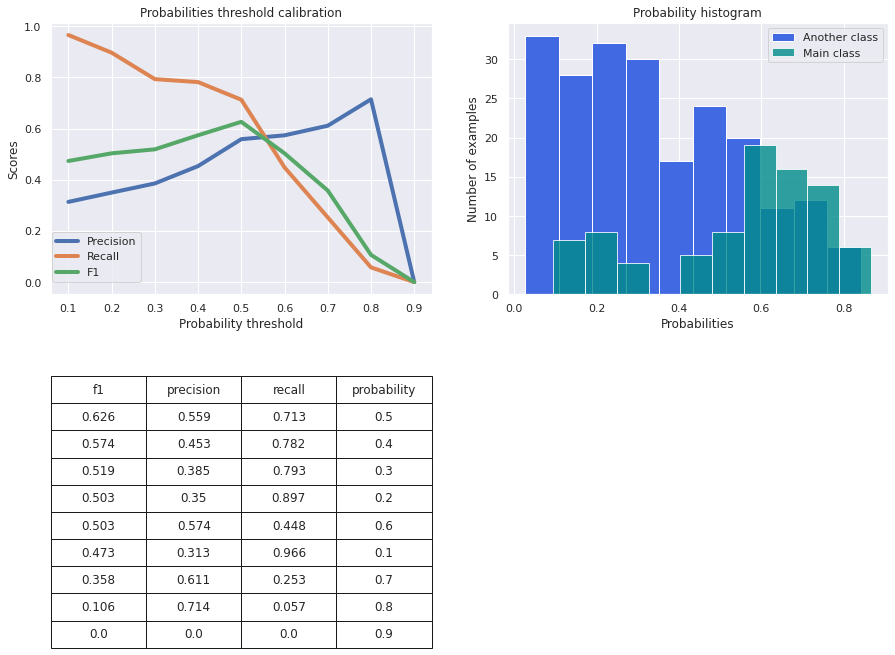

In [ ]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

Общая точка находится в диапазоне от 0.5 до 0.6

## Обучение финальной модели и оценка результатов

В качестве финальной модели однозначно останавливаемся на CatBoost, даже с базовыми гиперпараметрами эта модель показала лучшие результаты

In [ ]:
final_model = catb.CatBoostClassifier(class_weights=[0.71, 1.67], silent=True, random_state=21, depth=6, iterations=500, learning_rate=0.01)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_pred_probs = final_model.predict_proba(X_test)

*Оцениваем полученные результаты*

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       213
           1       0.56      0.71      0.63        87

    accuracy                           0.75       300
   macro avg       0.71      0.74      0.72       300
weighted avg       0.78      0.75      0.76       300



Вывод: Задание выполнено